In [30]:
#Importing Libraries
import pandas as pd
import numpy as np
import glob
from datetime import date,timedelta
from nsepy import get_history
from pyfinance.ols import PandasRollingOLS
import statsmodels.api as sm
import talib as tb
import os

//anaconda3/lib/python3.7/site-packages/statsmodels/compat/pandas.py:23: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


In [5]:
PATH = 'Data/'

In [22]:
def portfolioCreator(filter_name="",PATH = 'Data/'):
    """
    Creates a dictionary of dataframes(dates*stocks) of Close,
    Open,High,Low and Turnover
    """
    
    #Reading the dates and allocating memory
    dates = pd.read_csv(os.path.join(PATH,'dates.csv'),header = None,names = ["Date"])
    dates['Date'] = pd.to_datetime(dates['Date'],yearfirst = True)
    files = glob.glob(os.path.join(PATH,'nse_*.csv'))
    portfolio = dict()
    
    for file in files:
        
        df = pd.read_csv(file)
        df['_id']= dates['Date']
        df.set_index('_id',inplace = True)
        df.index.names = ['Date']
        
        #Creating the Universe
        
        if(filter_name == 'NIFTY'):
            ticker_list = pd.read_csv(os.path.join(PATH,'ind_nifty50list.csv'))['Symbol']
        elif(filter_name == 'FNO'):
            ticker_list = pd.read_csv(os.path.join(PATH,'fno_list.csv'))['Symbol']
        else:
            ticker_list = df.columns
            
        df = df.loc[:,ticker_list].dropna(axis=1, how='all')
        portfolio[file[file.find('.')+1:file.rfind('.')]] = df
        
    return portfolio

In [23]:
portfolio = portfolioCreator()

In [25]:
def createFilter(df = pd.DataFrame(),N = 200):
    """
    Creates a filter based on n-day Moving Average
    """
    
    _filter = pd.DataFrame(index = df.index,columns = df.columns)
    
    for stock in df.columns:
        _filter.loc[:,stock] = df[stock]>df[stock].rolling(N).mean()
    _filter.index = pd.to_datetime(_filter.index,yearfirst=True)
    
    return _filter

In [72]:
NIFTY = pd.read_csv(os.path.join(PATH,'NIFTY50.csv'),index_col = 'Date',usecols = ['Date','Close'])
nifty_filter = createFilter(NIFTY,200)

stock_filter = createFilter(portfolio['Close'],100)

In [48]:
def regressionRunner(portfolio = dict()):
    df = np.log(portfolio['Close'])
    df = df.reset_index()
    date_idx = df.Date
    df = df.drop(['Date'],axis=1)
    
    rsq = pd.DataFrame(index= df.index, columns=df.columns)
    beta = pd.DataFrame(index= df.index, columns=df.columns)
    
    for stock in df.columns:
        model = PandasRollingOLS(y=df[stock],x=df.index, window=90,has_const=False)
        rsq[stock]= model.rsq[model.rsq<1]
        beta[stock]=model.beta
        
    rsq.index = date_idx
    beta.index = date_idx
    return beta,rsq

In [49]:
beta,rsq = regressionRunner(portfolio)

In [51]:
def ATR(portfolio = dict()):
    
    atr_20 = pd.DataFrame(index= portfolio['High'].index, columns=portfolio['High'].columns)
    for stock in atr_20.columns:
        atr_20[stock]=tb.ATR(portfolio['High'][stock], portfolio['Low'][stock], portfolio['Close'][stock], timeperiod=20)
        
    return atr_20

In [53]:
ATR20 = ATR(portfolio)

In [55]:
def ranker(toRank = pd.DataFrame()):
    """
    Returns the daily ranking of all the stocks in the 
    universe excluding NaNs
    """
    return (toRank).rank(axis=1,ascending = False)

In [56]:
daily_rank = ranker(beta*rsq)

In [59]:
def reDate(dates,day):
    """
    Returns the dates of rebalancing weekly.
    If that day exchange is closed, rebalanced 
    on next possible day.
    """
    updated_dates = list()
    date_cnt = 0
    for date_idx in dates:
        if(date_idx.weekday() == day):
            updated_dates.append(date_idx)
            date_cnt = 0
        else:
            date_cnt += 1
            
        if(date_cnt == 5):#Incase that day is a holiday
            date_cnt = 0
            updated_dates.append(date_idx)
            
    return updated_dates

In [60]:
updated_dates = reDate(daily_rank.index,2)

In [61]:
def backtest(portfolio = dict(),updated_dates = [],nifty_filter = pd.Series(),
             stock_filter = pd.DataFrame(),daily_rank = pd.DataFrame(),initial_capital = 1000000,risk_factor = 0.01
             ,brokerage_rate = 0.0002):
    """
    
    """
    daily_rank = daily_rank*stock_filter
    daily_rank = daily_rank.replace(0,np.NaN)
    close = portfolio['Close']

    holdings = pd.Series(index = close.index)
    booksize = pd.Series(index = close.index)
    brokerage = pd.Series(index = close.index)
    daily_pnl = pd.Series(index = close.index)

    daily_dfs = []
    yesterday_idx = updated_dates[0]
    
    for date_idx in updated_dates:
        if(nifty_filter.loc[date_idx,'Close'] == False and len(daily_dfs) != 0):
            
            to_sell = (stock_filter.loc[date_idx,:][stock_filter.loc[date_idx,:] == False].index)
            
            holdings[date_idx] = list(set(holdings[yesterday_idx]) - set(to_sell))
            to_sell = list(set(holdings[yesterday_idx]) & set(to_sell))
            prev_df = daily_dfs[-1]

            daily_pnl[date_idx] = (close.loc[date_idx,to_sell]*prev_df.loc[to_sell,'qty']-prev_df.loc[to_sell,'exposure']).sum()
            brokerage[date_idx] = ((close.loc[date_idx,to_sell]*prev_df.loc[to_sell,'qty']+prev_df.loc[to_sell,'exposure'])*brokerage_rate).sum()

            cash = booksize[yesterday_idx]+daily_pnl[date_idx]-brokerage[date_idx]
            booksize[date_idx] = min(initial_capital,cash)
                
            yesterday_idx = date_idx

        else:
            today_df = pd.DataFrame(index = close.columns,columns=['rank', 'qty', 'price','exposure'])
            if len(daily_dfs) == 0:
                
                booksize[date_idx] = initial_capital
                daily_pnl[date_idx] = 0
                brokerage[date_idx] = 0
                
                today_df['rank'] = daily_rank.loc[date_idx,:]
                today_df['price'] = close.loc[date_idx, :]
                today_df['qty'] = np.floor((booksize[date_idx]*risk_factor)/(ATR20.loc[date_idx,:]))
                today_df['exposure'] = today_df['qty']*today_df['price']
                today_df = today_df.sort_values('rank')
                holdings[date_idx] = today_df[(today_df['exposure'].cumsum()<booksize[date_idx])].index

            else:
                prev_df = daily_dfs[-1]
                prev_univ = holdings[yesterday_idx]

                today_df['rank'] = daily_rank.loc[date_idx,:]
                today_df['price'] = close.loc[date_idx, :]

                daily_pnl[date_idx] = (today_df.loc[prev_univ,'price']*prev_df.loc[prev_univ,'qty']-prev_df.loc[prev_univ,'price']*prev_df.loc[prev_univ,'qty']).sum()
                brokerage[date_idx] = ((today_df.loc[prev_univ,'price']*prev_df.loc[prev_univ,'qty']+prev_df.loc[prev_univ,'price']*prev_df.loc[prev_univ,'qty'])*brokerage_rate).sum()

                cash = booksize[yesterday_idx]+daily_pnl[date_idx]-brokerage[date_idx]
                booksize[date_idx] = min(initial_capital,cash)
                
                today_df['qty'] = np.floor((booksize[date_idx]*risk_factor)/(ATR20.loc[date_idx,:]))
                today_df['exposure'] = today_df['qty']*today_df['price']
                today_df = today_df.sort_values('rank')
                holdings[date_idx] = today_df[(today_df['exposure'].cumsum()<booksize[date_idx])].index
            
            daily_dfs.append(today_df)
            yesterday_idx = date_idx
    
    daily_pnl = daily_pnl.fillna(0)
    brokerage = brokerage.fillna(0)
    booksize = booksize.ffill()
    booksize = booksize.bfill()
    return daily_pnl,booksize,brokerage

In [83]:
pnl,cap,bkg = backtest(portfolio,updated_dates,nifty_filter,stock_filter,daily_rank)

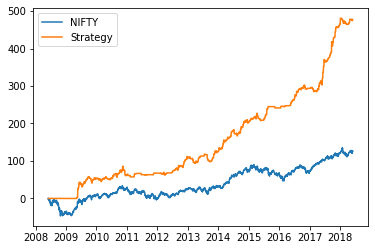

In [84]:
import matplotlib.pyplot as plt

plt.plot(pnl.index,(NIFTY/NIFTY.iloc[0,:]-1) * 100,label = 'NIFTY')
plt.plot(pnl.index,(pnl.cumsum()/1000000) * 100,label= 'Strategy')
plt.legend()